In [1]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
sns.set()

In [2]:
from covid_tracking_data.collector import *
from covid_analysis.utility import *
from covid_analysis.models import *
from ourworldindata_org.collector import *

In [3]:
 from matplotlib.axes._axes import _log as matplotlib_axes_logger
 matplotlib_axes_logger.setLevel('ERROR')

### Fetch the latest data

If the interface is overloaded, the collector will retry every few seconds.

In [4]:
df, states_in_order = get_dataset_df()
df = add_population_column(df)
fns = save_data(df, states_in_order)
print("data saved to {} and {}".format(*fns))

data saved to /home/scott/data/2020-09-05_2335_state_daily_data.csv and /home/scott/data/2020-09-05_2335_state_rank.csv


### Fetch data set from local disk

In [5]:
!ls ~/data/
# gets thte latest file names
recent = ! ls -drt ~/data/* | tail -n 2
print("Latest files are:\n\t{}\n\t{}".format(*recent))

2020-09-03_0224_state_daily_data.csv  2020-09-05_2308_state_rank.csv
2020-09-03_0224_state_rank.csv	      2020-09-05_2311_state_daily_data.csv
2020-09-03_0234_state_daily_data.csv  2020-09-05_2311_state_rank.csv
2020-09-03_0234_state_rank.csv	      2020-09-05_2315_state_daily_data.csv
2020-09-05_2302_state_daily_data.csv  2020-09-05_2315_state_rank.csv
2020-09-05_2302_state_rank.csv	      2020-09-05_2335_state_daily_data.csv
2020-09-05_2308_state_daily_data.csv  2020-09-05_2335_state_rank.csv
Latest files are:
	/home/scott/data/2020-09-05_2335_state_rank.csv
	/home/scott/data/2020-09-05_2335_state_daily_data.csv


In [6]:
df, states_in_order = get_dataset_df_from_file(recent)
df.head()
print(states_in_order)

['CA', 'FL', 'TX', 'NY', 'GA', 'IL', 'AZ', 'NJ', 'NC', 'TN', 'LA', 'PA', 'AL', 'OH', 'VA', 'SC', 'MA', 'MI', 'MD', 'IN', 'MO', 'MS', 'WI', 'MN', 'WA', 'NV', 'IA', 'AR', 'OK', 'CO', 'UT', 'CT', 'KY', 'KS', 'NE', 'PR', 'ID', 'OR', 'NM', 'RI', 'DE', 'SD', 'DC', 'ND', 'WV', 'HI', 'MT', 'NH', 'AK', 'ME', 'WY', 'GU', 'VT', 'VI', 'MP', 'AS']


In [7]:
dfus = get_state_df(df, "*", additional_aggregation_keys=["negative", "pending", "population"])
dfus["sum_of_tests"] = dfus["positive"] + dfus["negative"] + dfus["pending"]
dfus.tail()

date   positive  daily_new_positive     death  daily_new_death  \
223 2020-09-01  6042583.0               42423  176640.0             1027   
224 2020-09-02  6073187.0               30604  177672.0             1032   
225 2020-09-03  6117481.0               44294  178742.0             1070   
226 2020-09-04  6168994.0               51513  179740.0              998   
227 2020-09-05  6213630.0               44636  180655.0              915   

          tests    negative  pending   population  sum_of_tests  
223  78997333.0  72405542.0   6647.0  331433217.0    78454772.0  
224  79646904.0  73019975.0   9293.0  331433217.0    79102455.0  
225  80381085.0  73699205.0   9987.0  331433217.0    79826673.0  
226  81293103.0  74549817.0  10118.0  331433217.0    80728929.0  
227  82099363.0  75307433.0   9021.0  331433217.0    81530084.0

### Zero-day normalized log of total verified covid-19 cases

Improvment in flattening slopes. (The "grass" blows over to the right.)

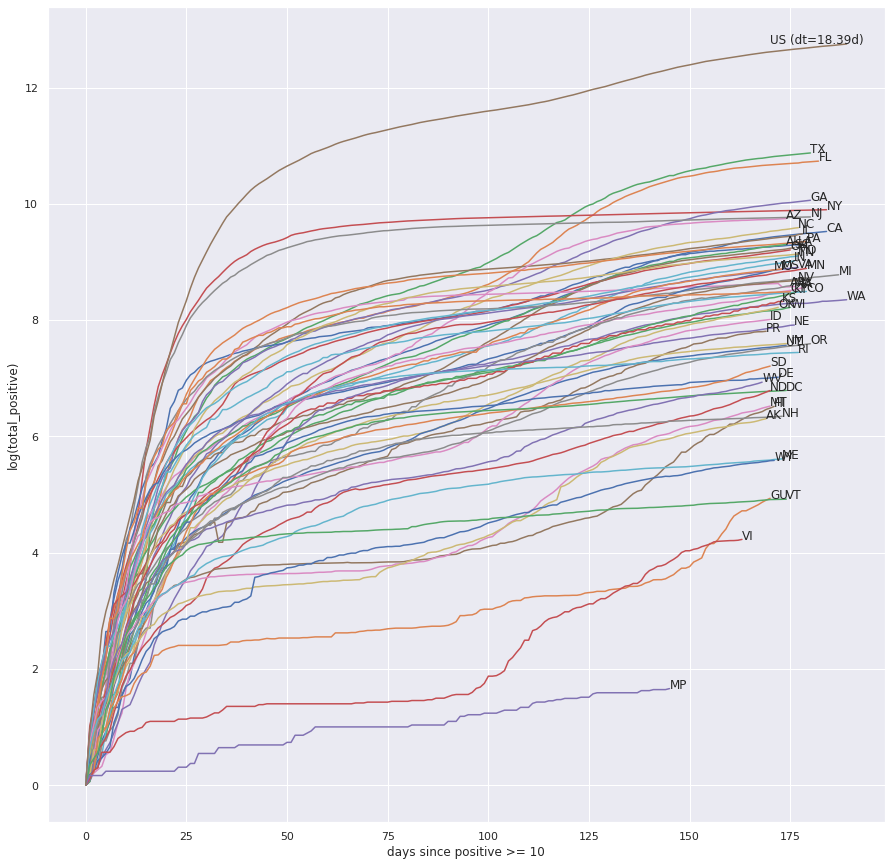

In [8]:
# start after day with min_pos or more cases
min_pos = 10
last_n_days = None

# image
plt.figure(figsize=[15,15])

key_value = "days_since_{}".format(min_pos)

# state by state
for s in states_in_order:
    try:
        dfq = get_state_df(df, s)
        dfq = get_zero_aligned_log_positive(dfq, min_pos=min_pos, use_last_n_days=last_n_days)
        plt.plot(dfq[key_value].values, dfq.log_positive.values)
        plt.annotate(s, (dfq[key_value].values[-1], dfq.log_positive.values[-1]))
    except IndexError:
        pass

# All US image
try:        
    dfq, dt, params = get_state_doubling_df(df, "*")
    dfq = get_zero_aligned_log_positive(dfq, min_pos=min_pos, use_last_n_days=last_n_days)
    plt.plot(dfq[key_value].values, dfq.log_positive.values)
    xus = int(.9* dfq[key_value].values[-1])
    plt.annotate("US (dt={:1.2f}d)".format(dt), (xus , dfq.log_positive.values[-1]))
except IndexError:
    pass

plt.xlabel("days since positive >= {}".format(min_pos))
plt.ylabel("log(total_positive)")
plt.show()

### US Total verifice covid-19 cases; current doubling period and history of doubling periods

Use the last few days to estimate the current doubling period. Plot the with past data for context.

US Total Positive, doubling every 1.03e+02 days
  as of 2020-01-22T00:00
  based on last 10 days of data


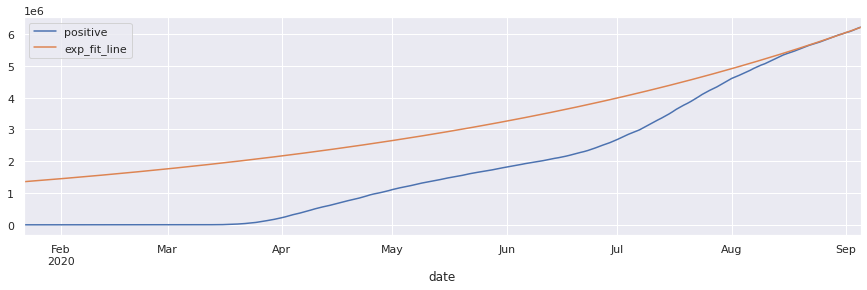

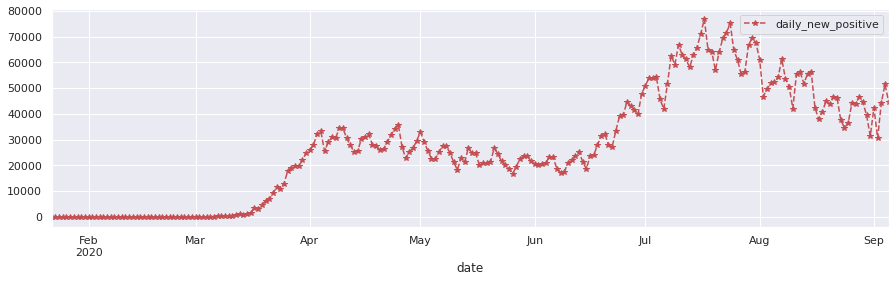

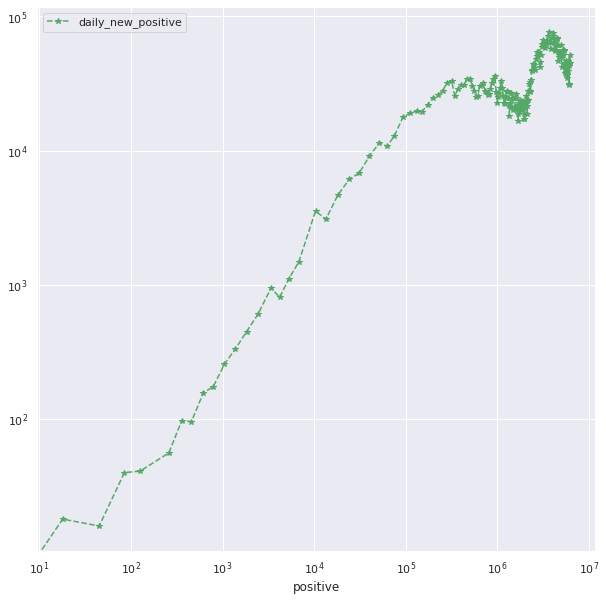

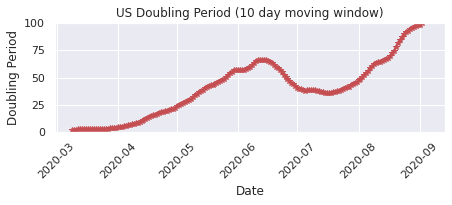

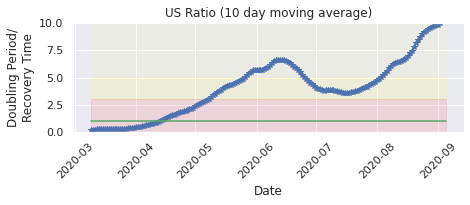

In [9]:
last_n_days = 10
dfa, dt, _ = get_state_doubling_df(df, "*", use_last_n_days=last_n_days)
lu = str(dfa.date.values[0])[:16]
print("US Total Positive, doubling every {:.3} days\n  as of {}".format(dt, lu))
print("  based on last {} days of data".format(last_n_days))
dfa.plot(x="date", y=["positive", "exp_fit_line"], figsize=[15,4])
dfa.plot(x="date", y="daily_new_positive", figsize=[15,4], style="*--r")
dfa.plot(x="positive", y="daily_new_positive", figsize=[10,10], style="*--g", logy=True, logx=True)
period_factor_plot(dfq, "*", ylimit=10)
plt.show()

### Testing data

Test positive rate is the number of covid-19 positive test over the total number of tests.

Uncertainty in the total number of tests due to the emerging private testing?

<AxesSubplot:xlabel='date'>

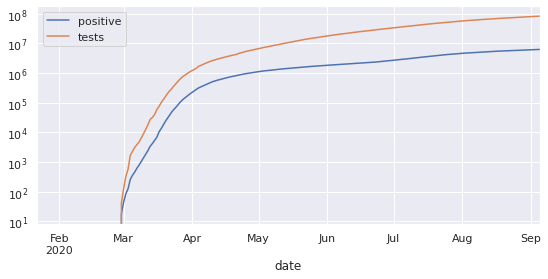

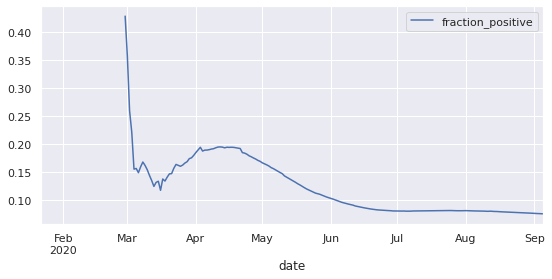

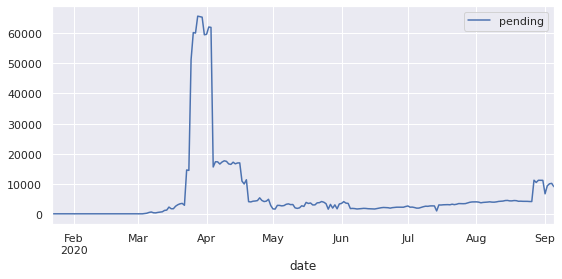

In [10]:
dfus["fraction_positive"] = dfus["positive"]/ dfus["tests"]
ax = dfus.plot(x="date", y="positive", logy=True, figsize=[9,4])
dfus.plot("date", "tests", logy=True, ax=ax)
dfus.plot("date", "fraction_positive", figsize=[9,4])
dfus.plot("date", "pending", figsize=[9,4])

### Current measured ratios and percentages; raw projections for the next few doubling periods

These are based on cases that test postive and test negative (state labs policies vary on this).

In [11]:
print("Current strategies for diagnosis give pos/neg tests ratio of {:.1%}".format(
    dfus.positive.values[-1]/(dfus.tests.values[-1])))
print("on total tests tracked = {:,}".format(int(dfus.tests.values[-1])))

Current strategies for diagnosis give pos/neg tests ratio of 7.6%
on total tests tracked = 82,099,363


In [12]:
pos_dr = dfus.death.values[-1]/dfus.positive.values[-1]
print("Current death/positive ratio of {:.1%}".format(pos_dr))

Current death/positive ratio of 2.9%


### State Trends and Doubling Periods

State=CA  (last_update=2020-03-04T00:00)
Doubling every 1.03e+02 days based on last 10 days of data


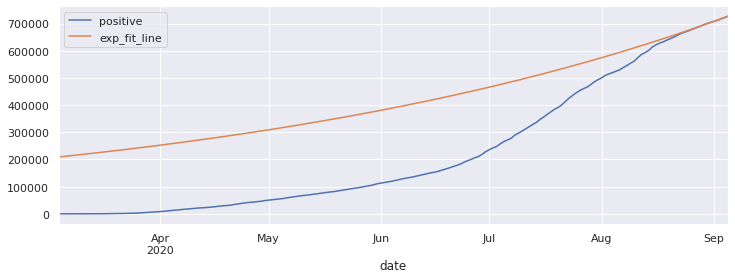

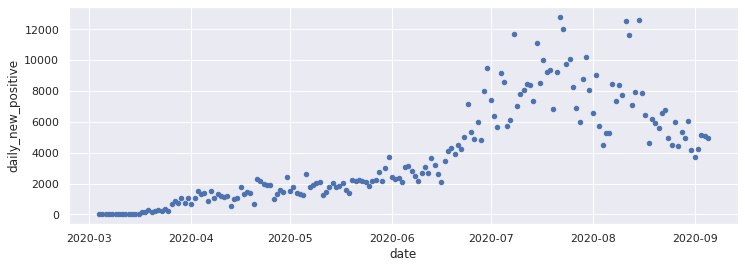

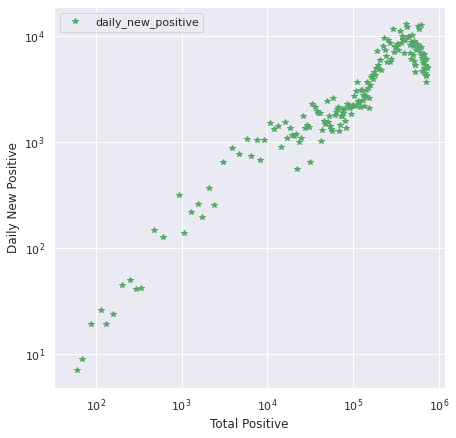

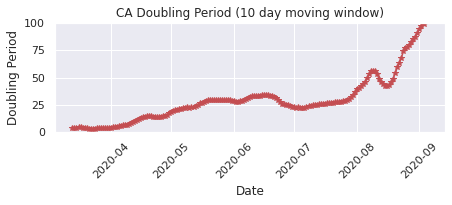

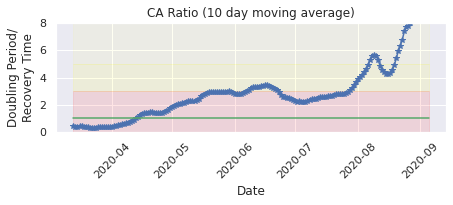

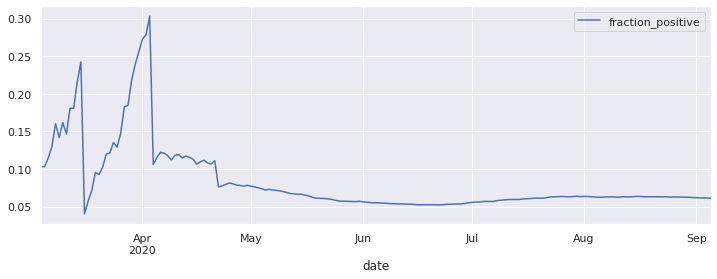

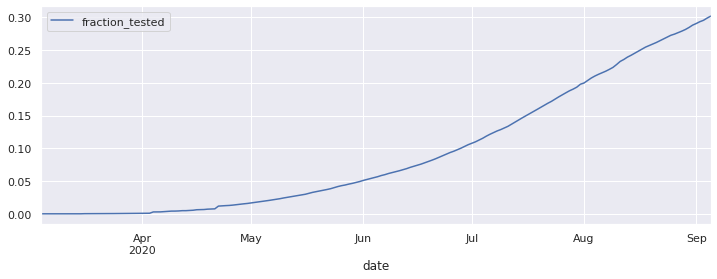

State=FL  (last_update=2020-03-04T00:00)
Doubling every 1.22e+02 days based on last 10 days of data


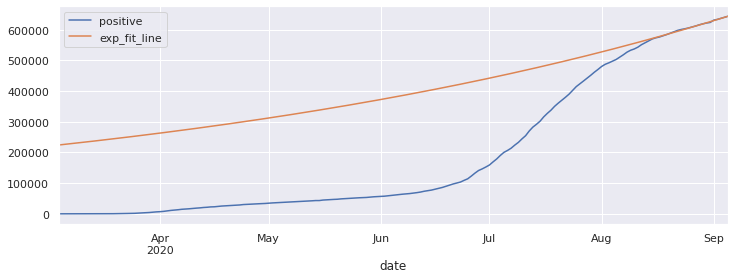

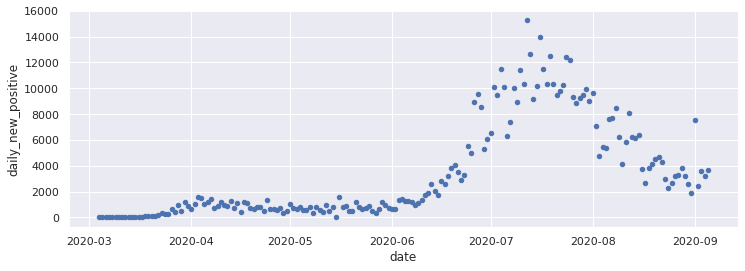

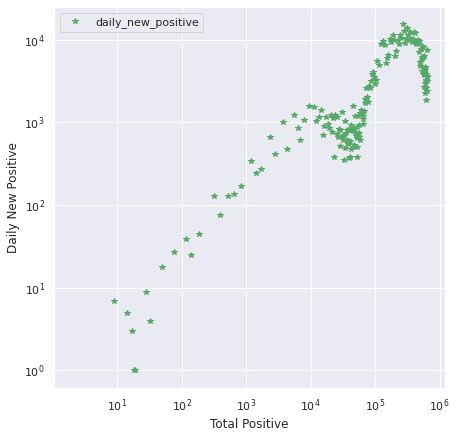

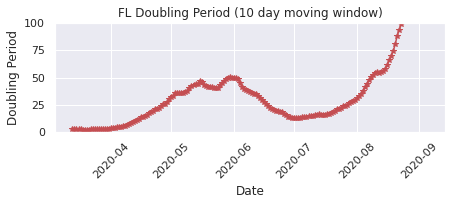

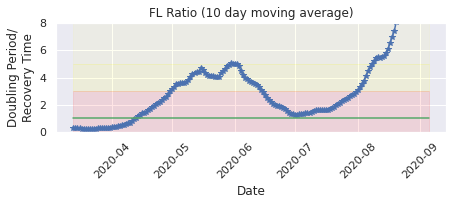

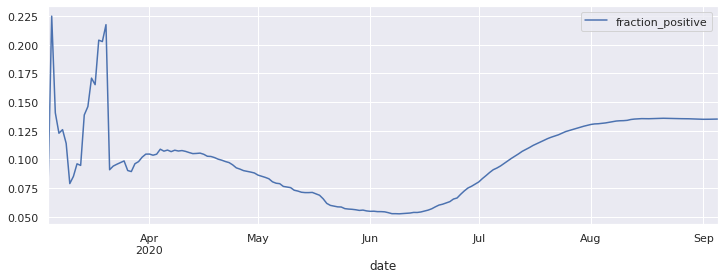

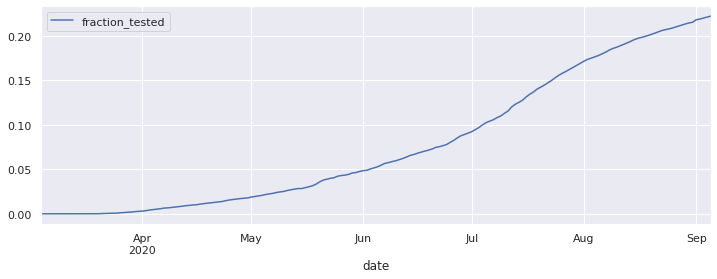

State=TX  (last_update=2020-03-04T00:00)
Doubling every 1.05e+02 days based on last 10 days of data


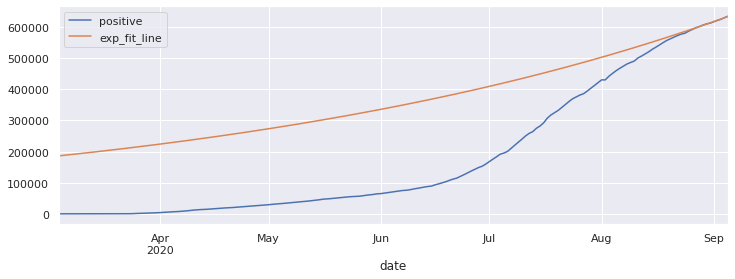

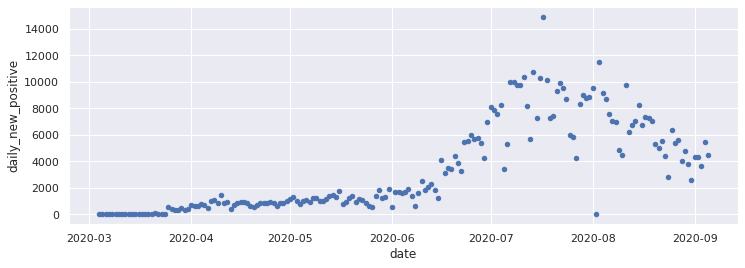

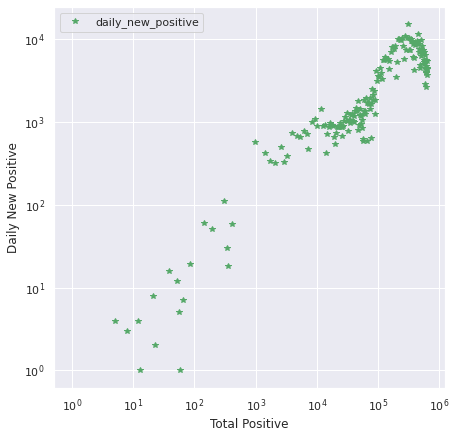

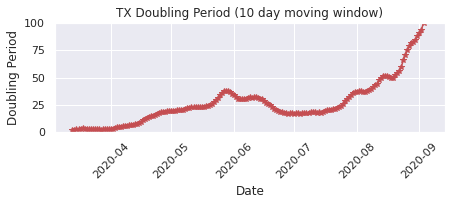

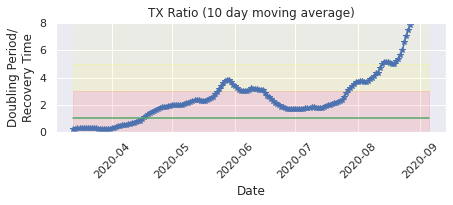

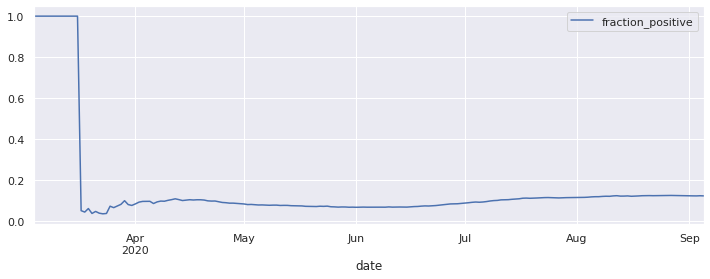

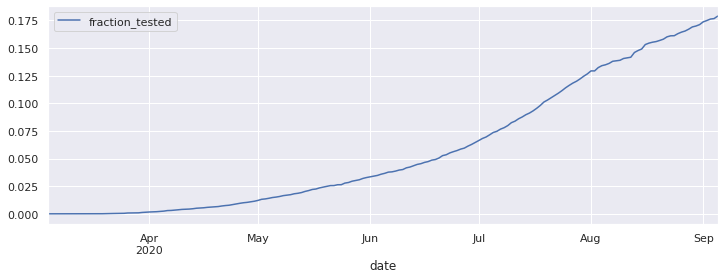

State=NY  (last_update=2020-03-04T00:00)
Doubling every 4.09e+02 days based on last 10 days of data


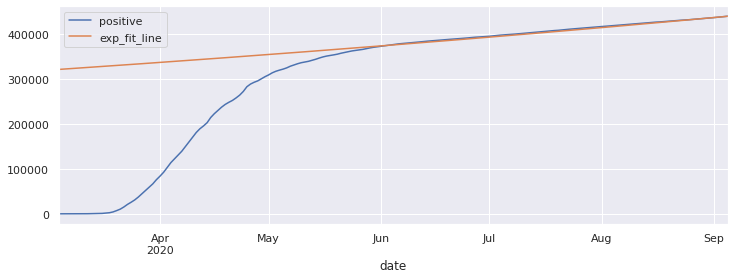

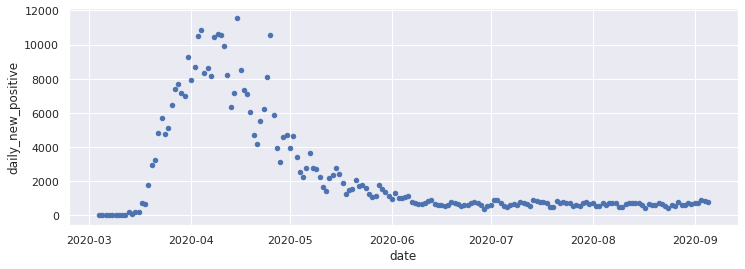

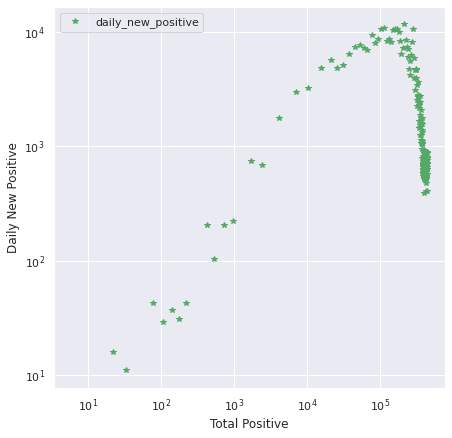

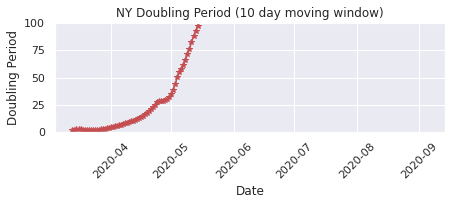

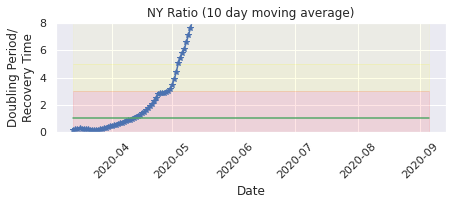

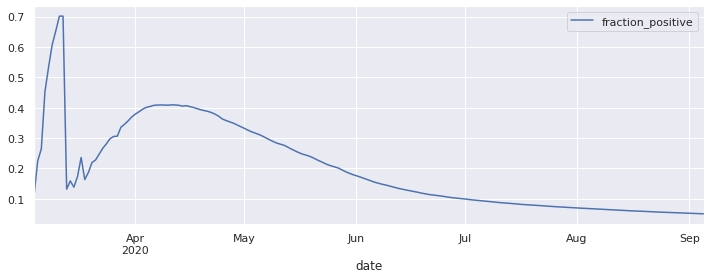

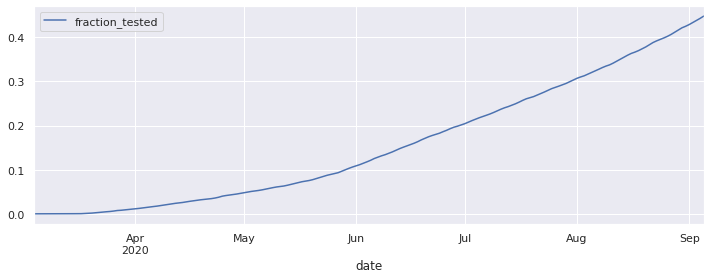

State=GA  (last_update=2020-03-04T00:00)
Doubling every 94.1 days based on last 10 days of data


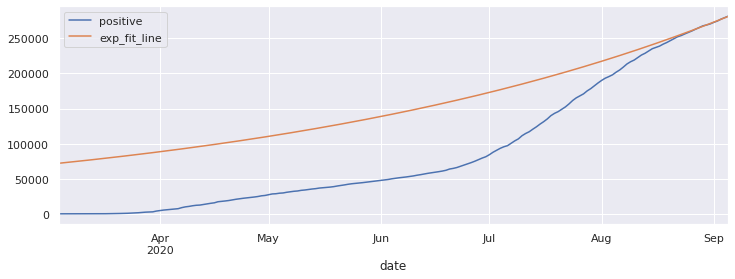

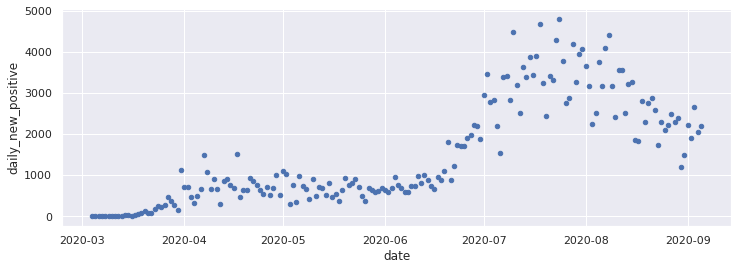

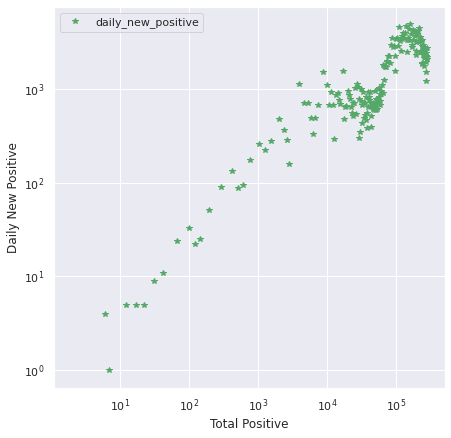

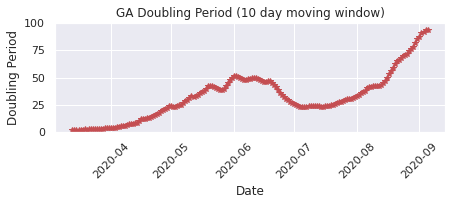

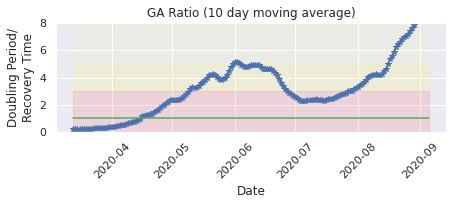

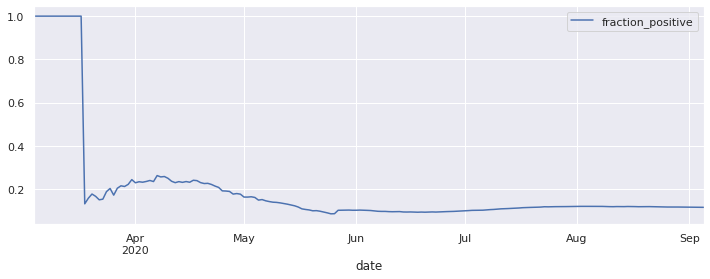

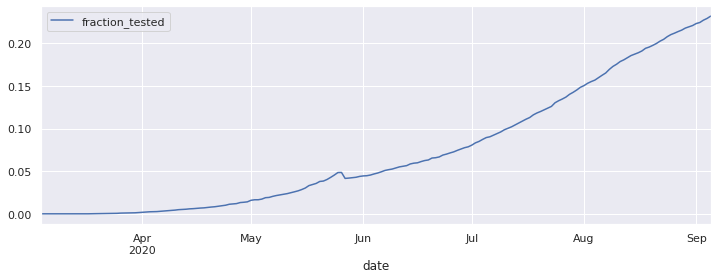

State=IL  (last_update=2020-03-04T00:00)
Doubling every 74.8 days based on last 10 days of data


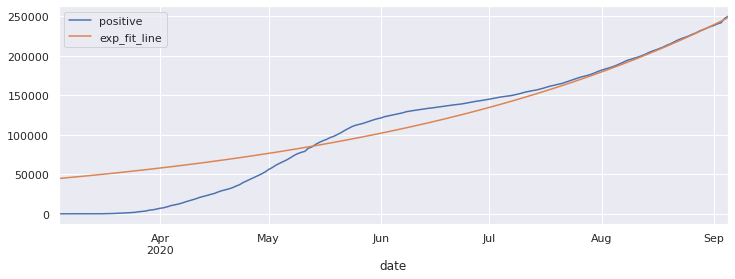

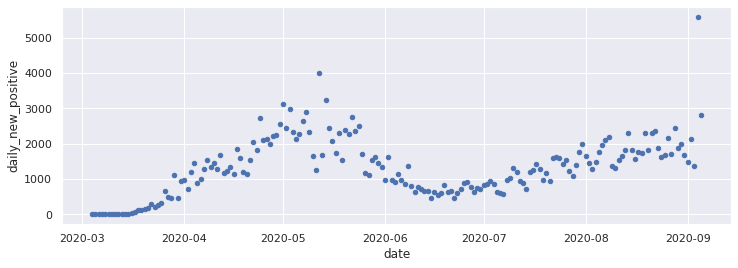

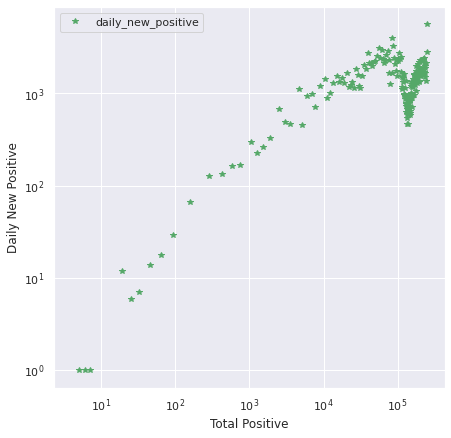

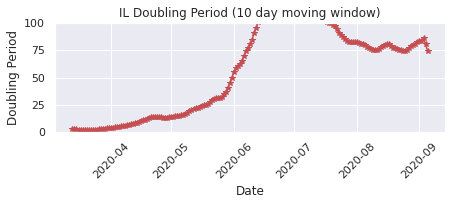

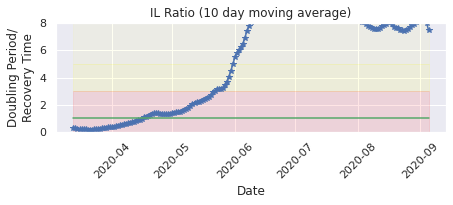

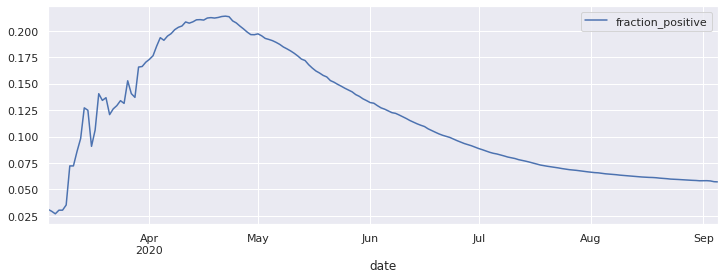

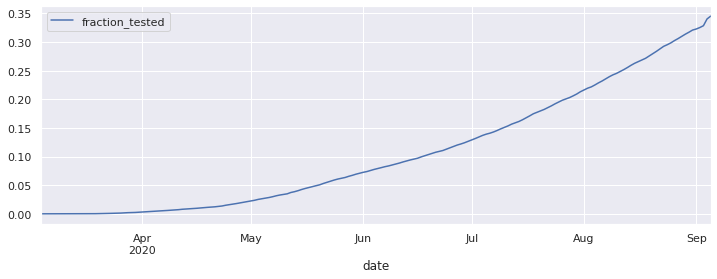

State=AZ  (last_update=2020-03-04T00:00)
Doubling every 2.47e+02 days based on last 10 days of data


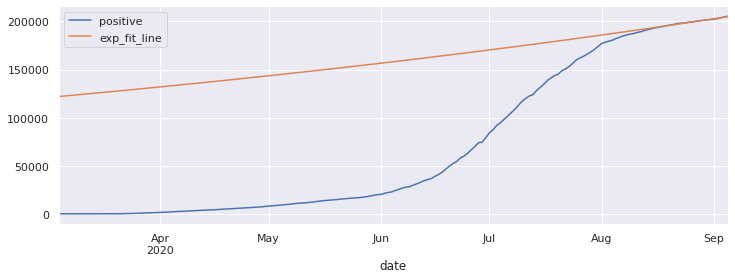

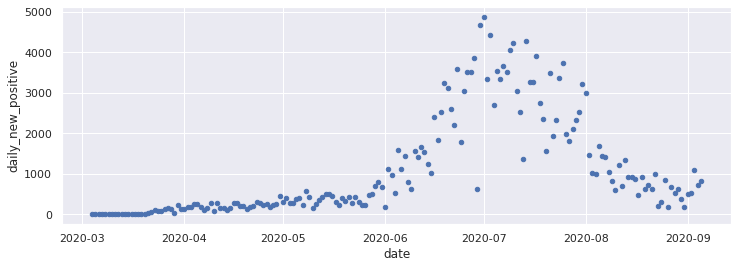

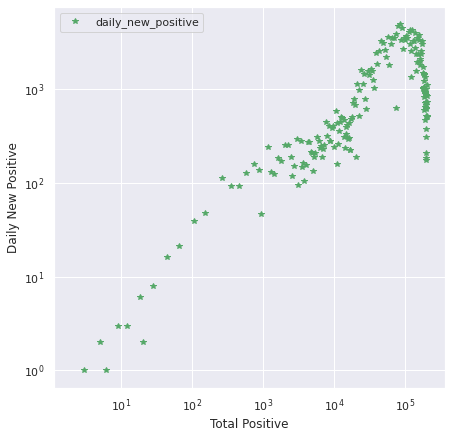

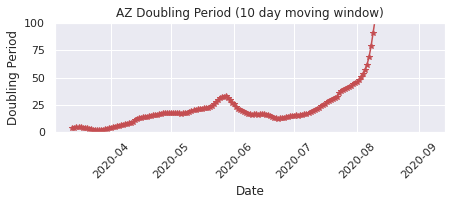

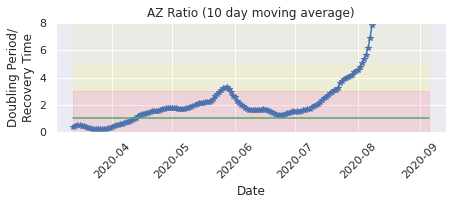

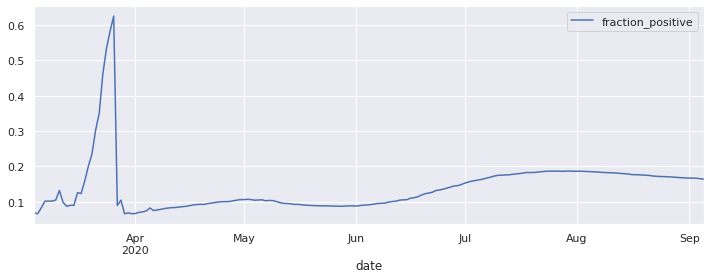

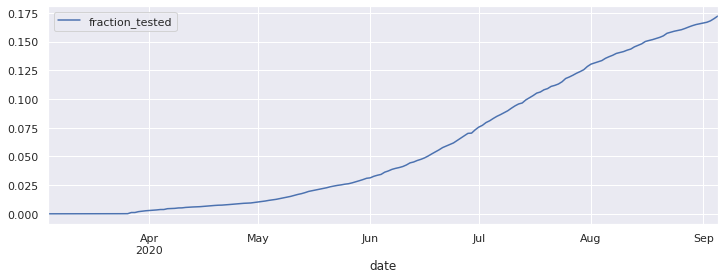

State=NJ  (last_update=2020-02-10T00:00)
Doubling every 3.86e+02 days based on last 10 days of data


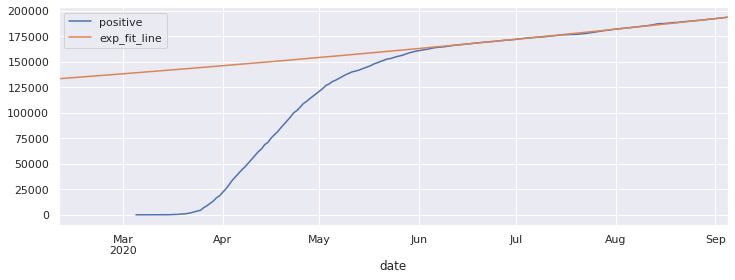

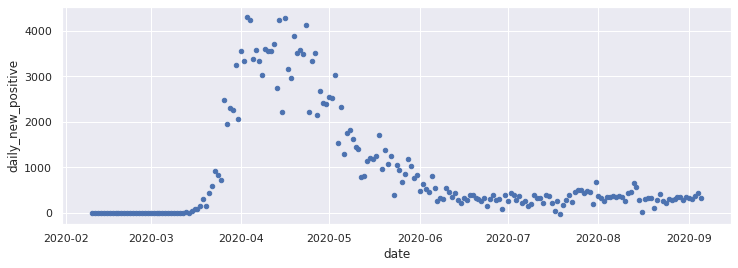

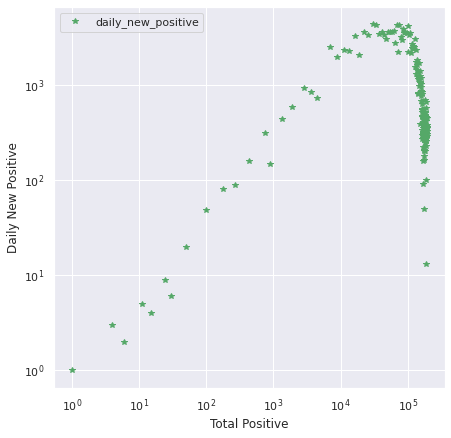

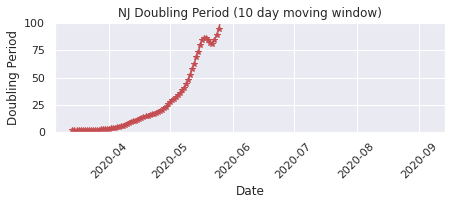

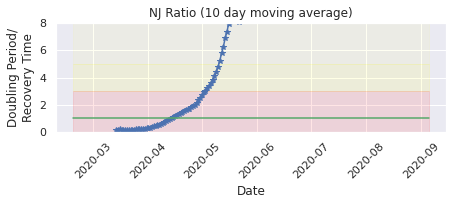

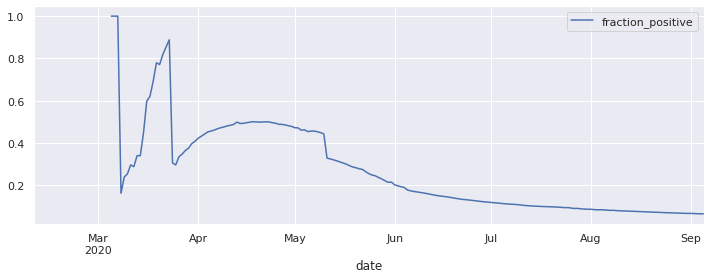

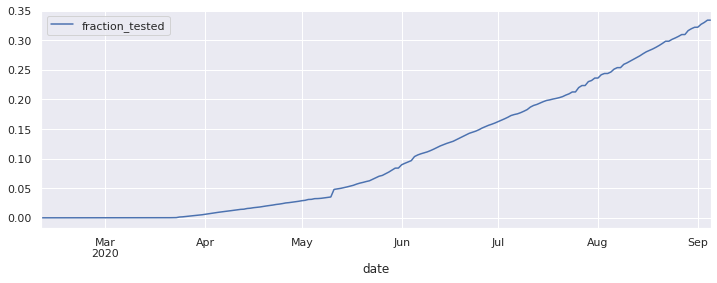

State=NC  (last_update=2020-03-04T00:00)
Doubling every 72.4 days based on last 10 days of data


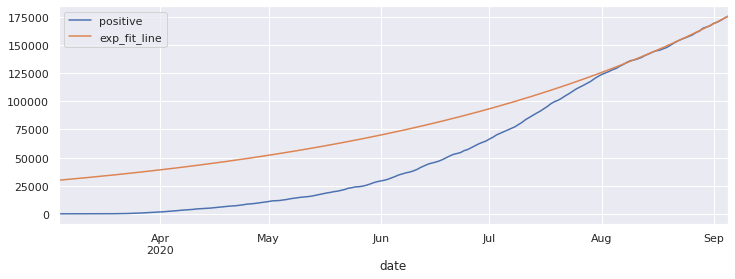

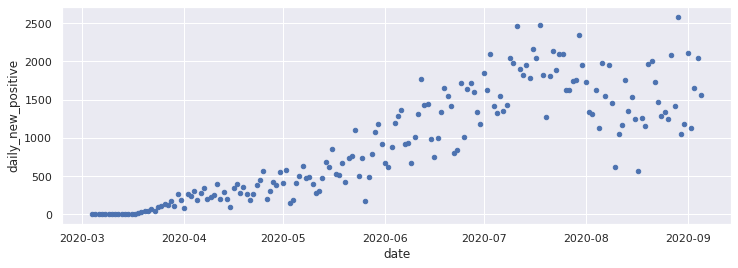

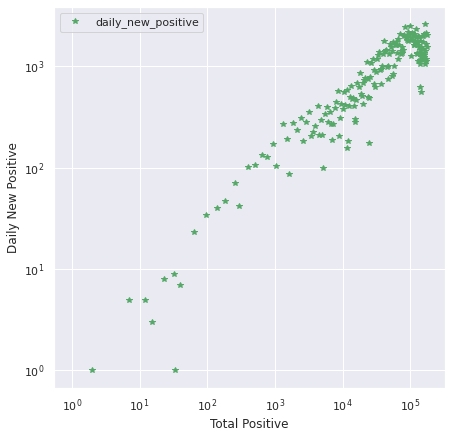

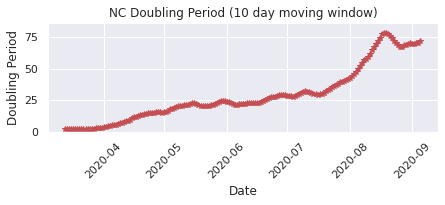

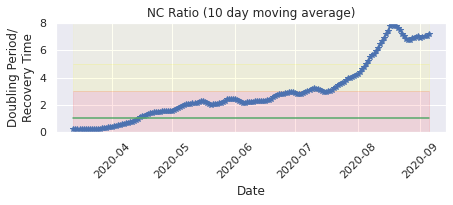

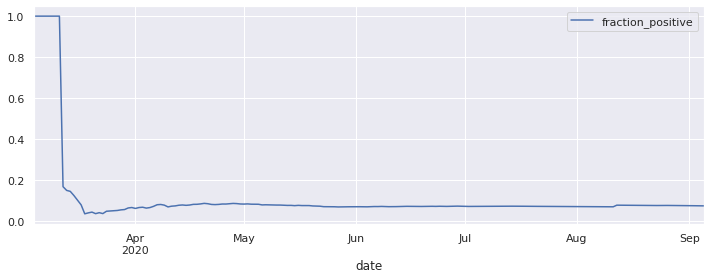

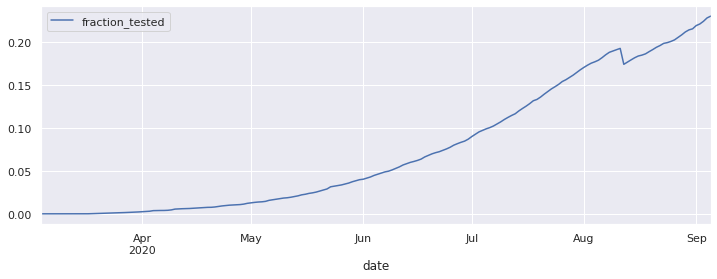

State=TN  (last_update=2020-03-05T00:00)
Doubling every 74.5 days based on last 10 days of data


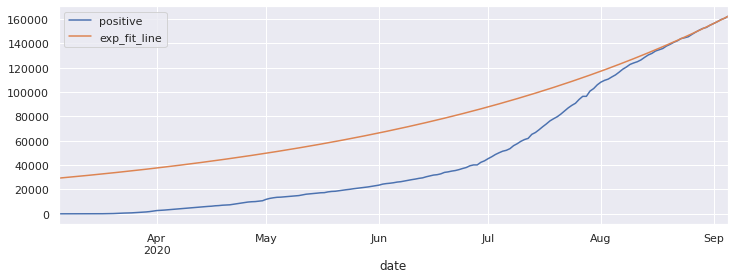

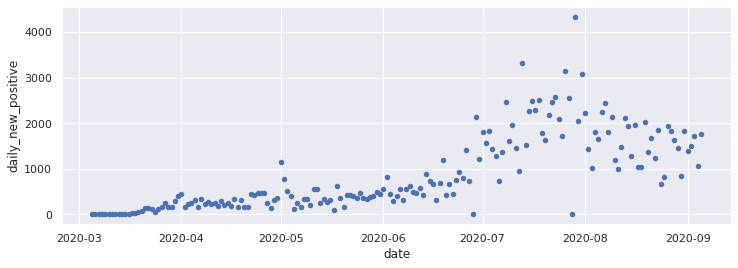

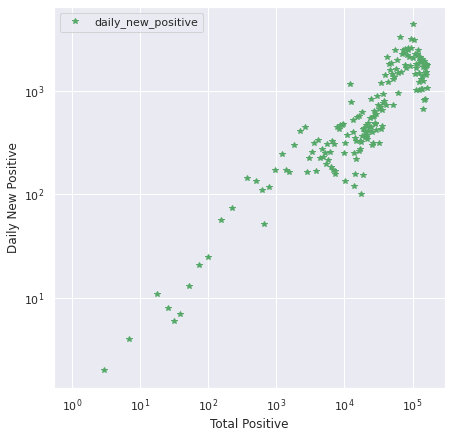

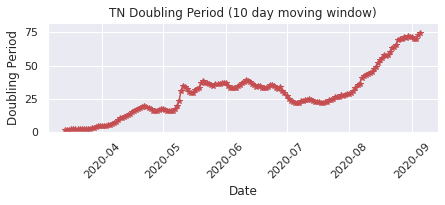

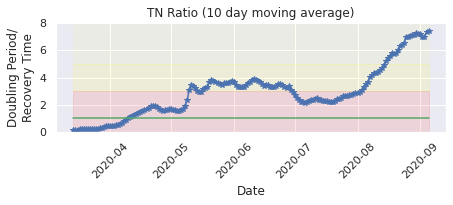

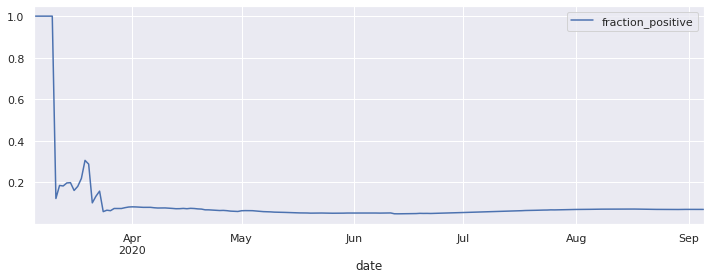

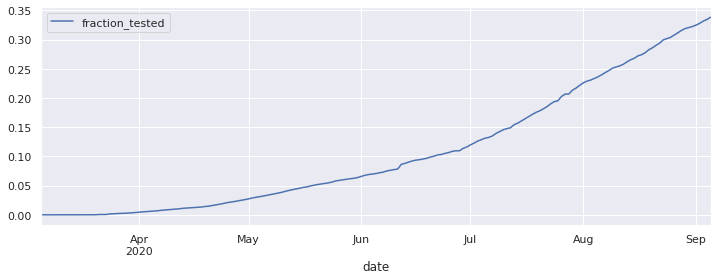

State=LA  (last_update=2020-03-07T00:00)
Doubling every 1.4e+02 days based on last 10 days of data


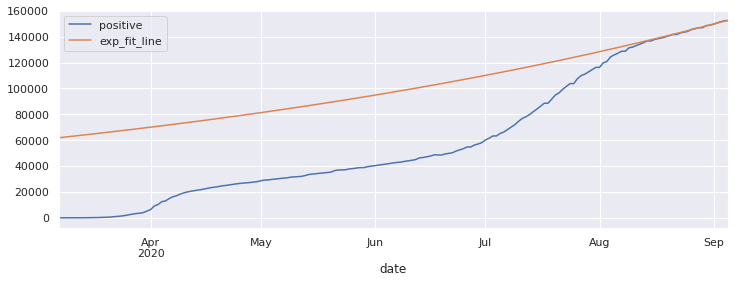

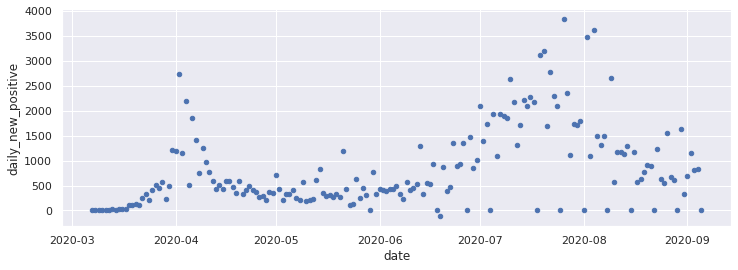

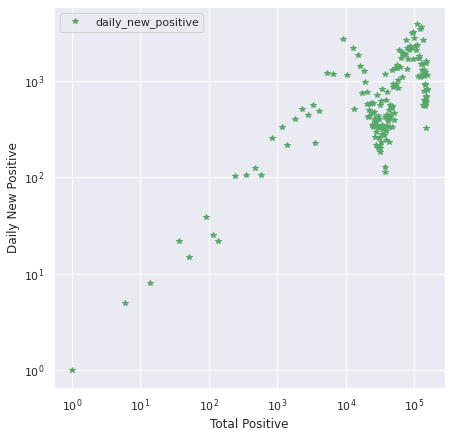

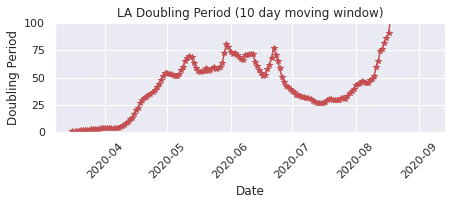

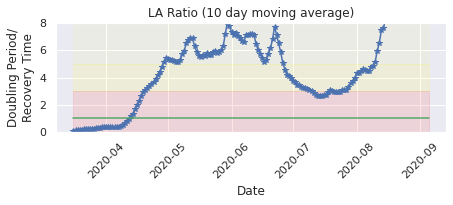

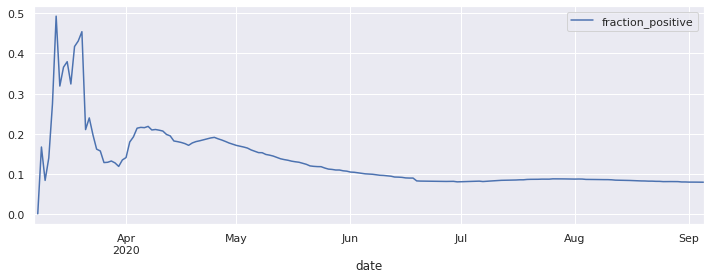

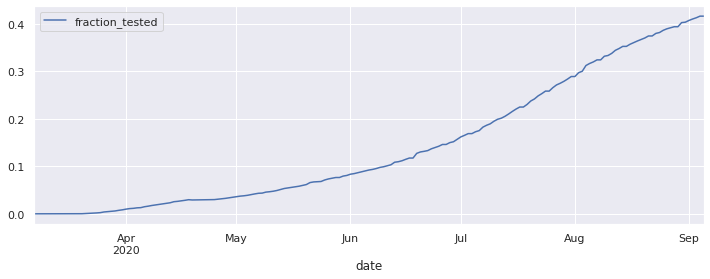

State=PA  (last_update=2020-03-06T00:00)
Doubling every 1.15e+02 days based on last 10 days of data


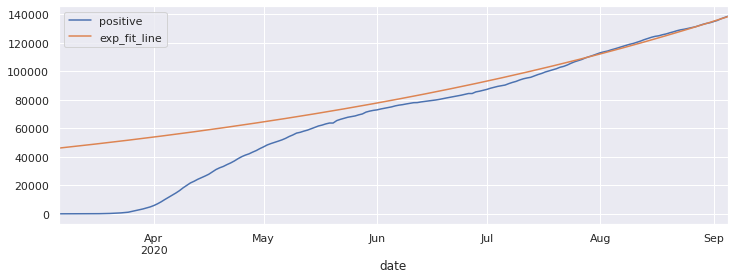

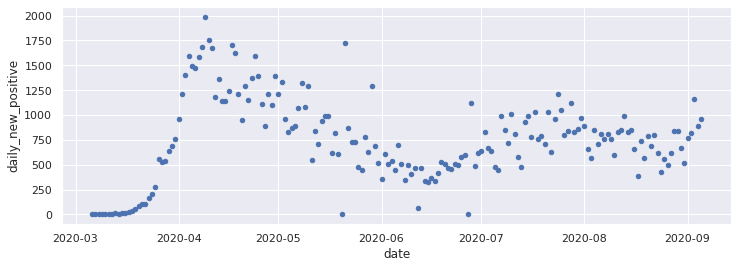

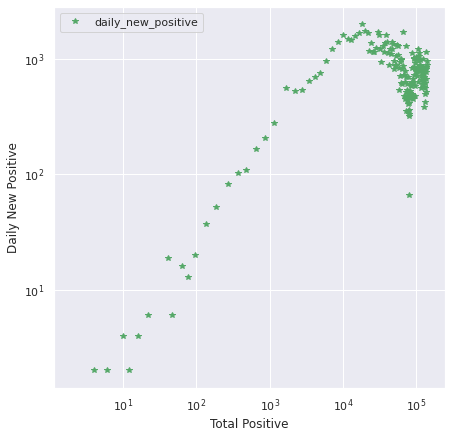

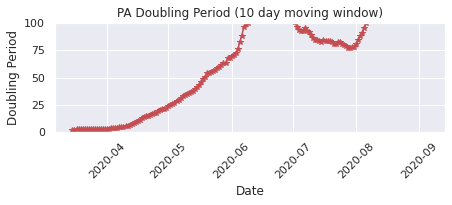

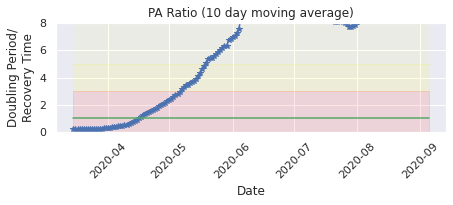

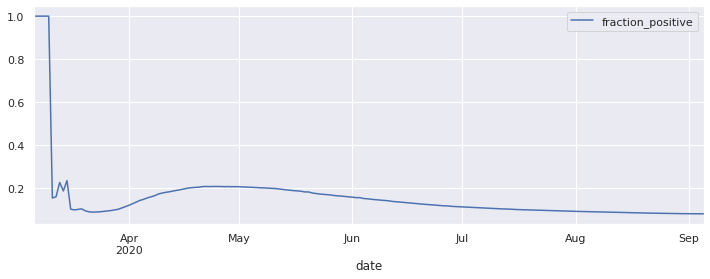

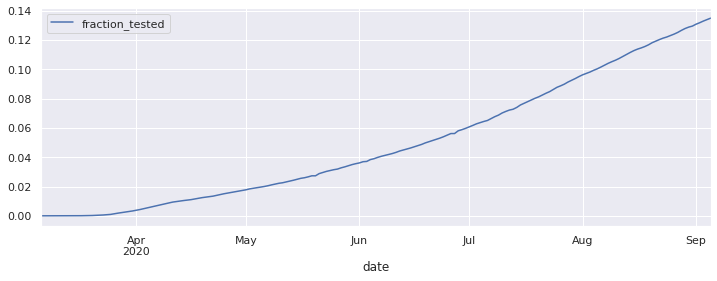

State=AL  (last_update=2020-03-07T00:00)
Doubling every 75.3 days based on last 10 days of data


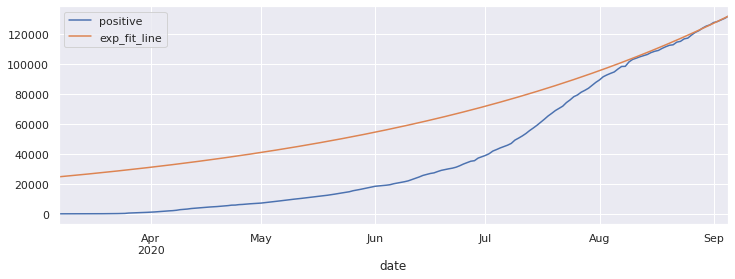

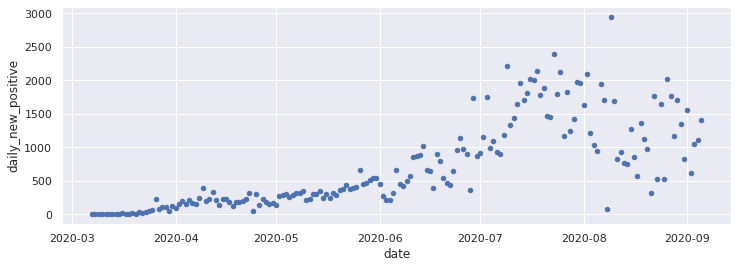

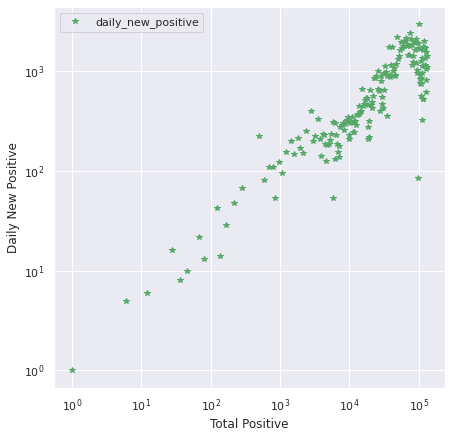

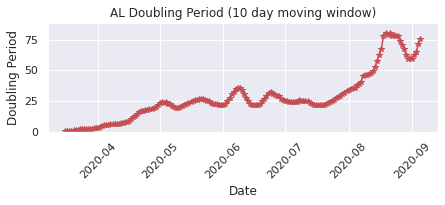

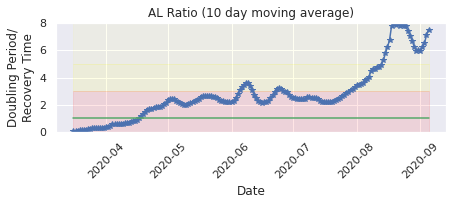

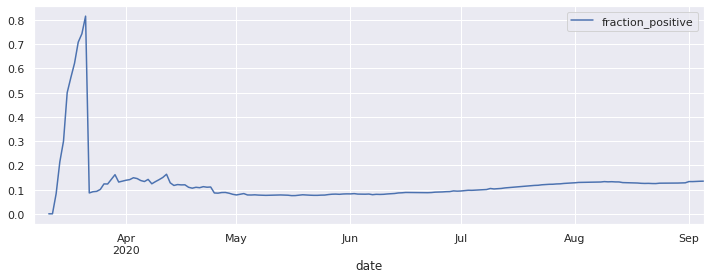

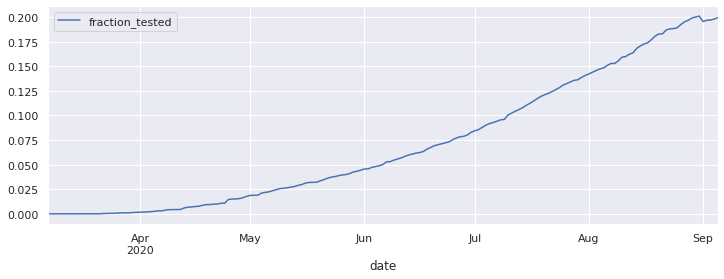

State=OH  (last_update=2020-03-05T00:00)
Doubling every 71.9 days based on last 10 days of data


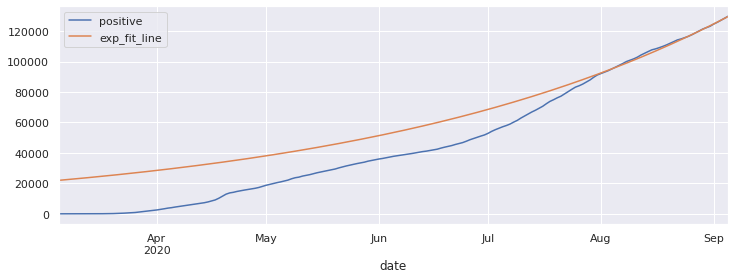

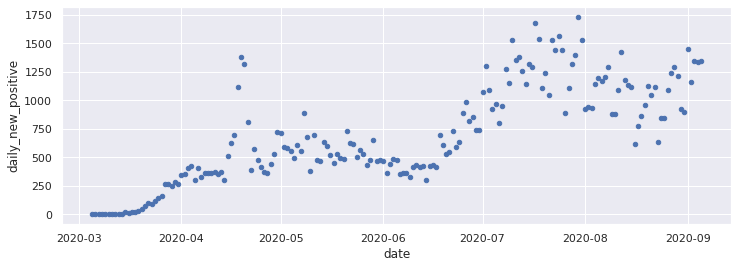

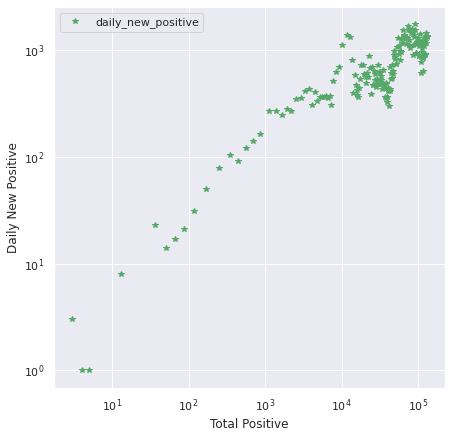

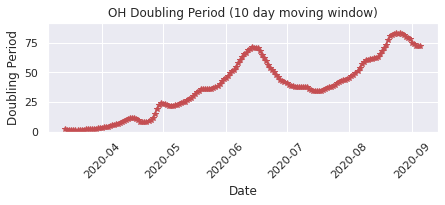

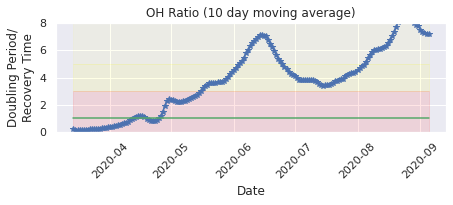

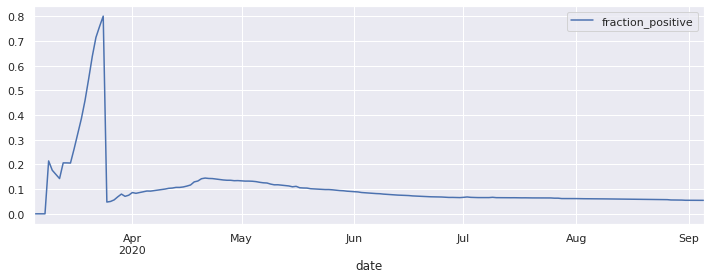

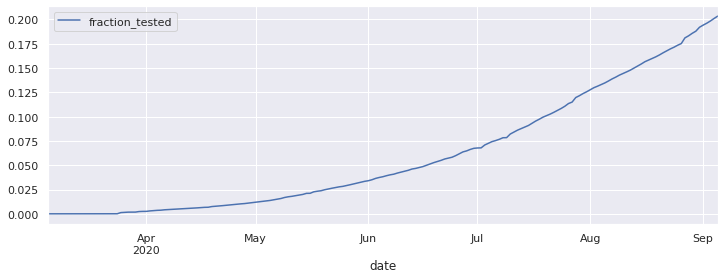

State=VA  (last_update=2020-02-27T00:00)
Doubling every 78.3 days based on last 10 days of data


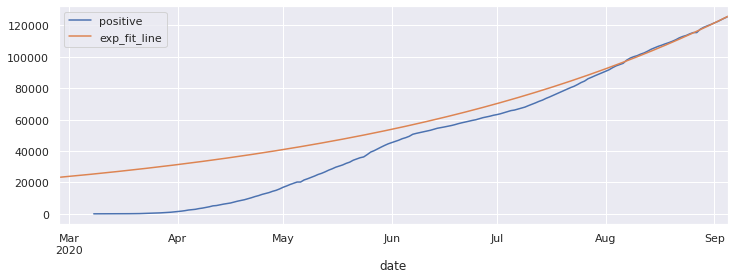

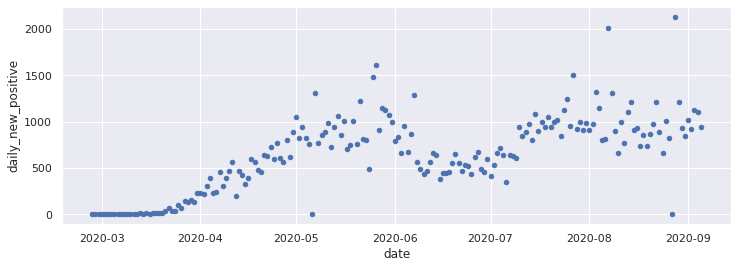

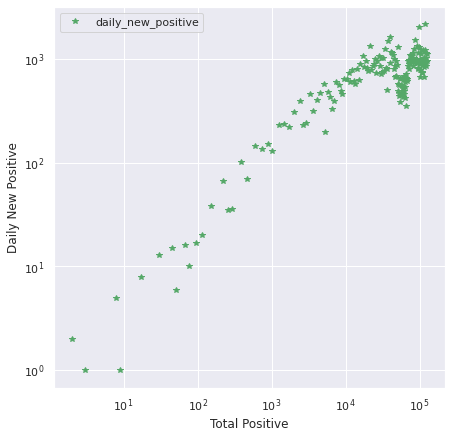

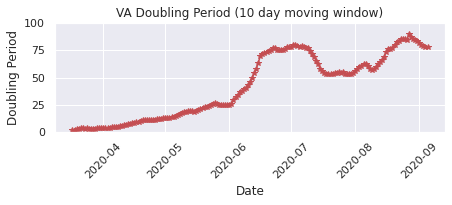

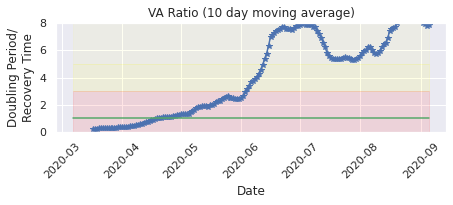

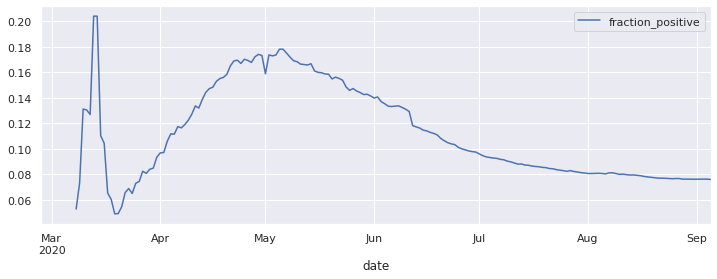

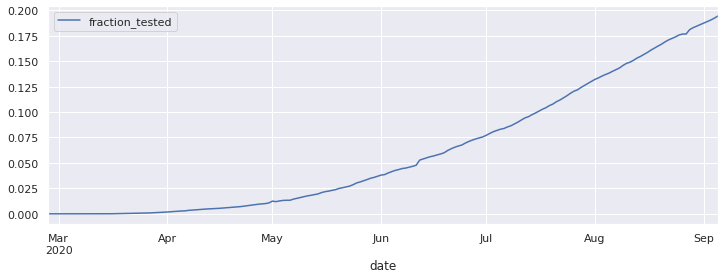

State=SC  (last_update=2020-03-04T00:00)
Doubling every 81.1 days based on last 10 days of data


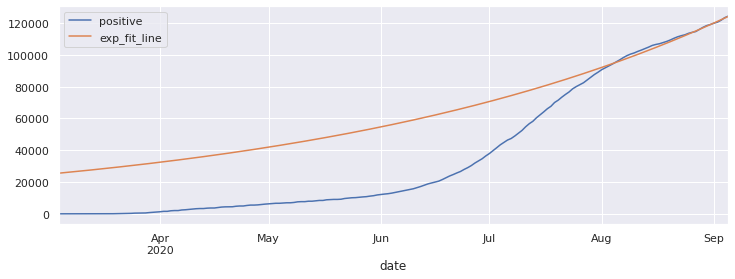

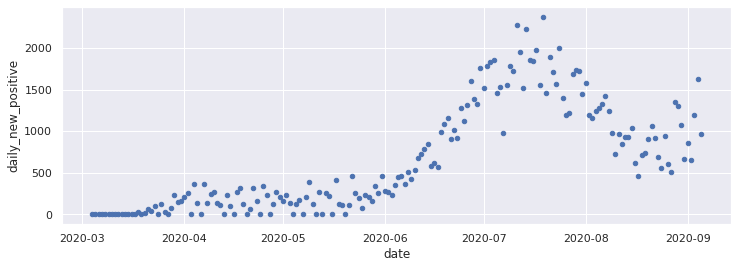

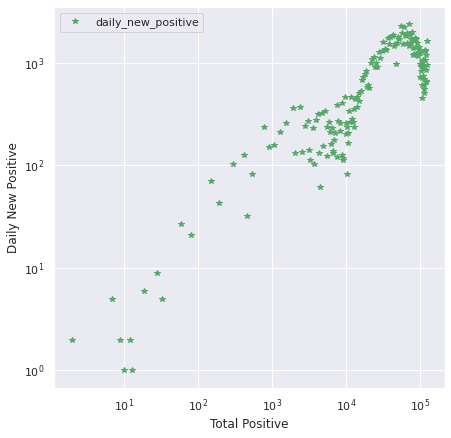

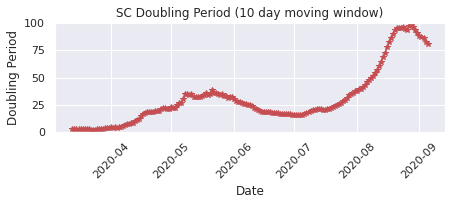

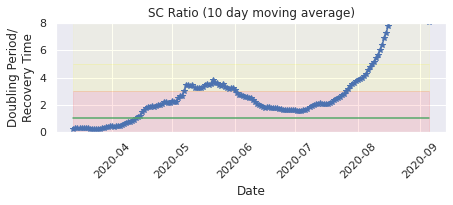

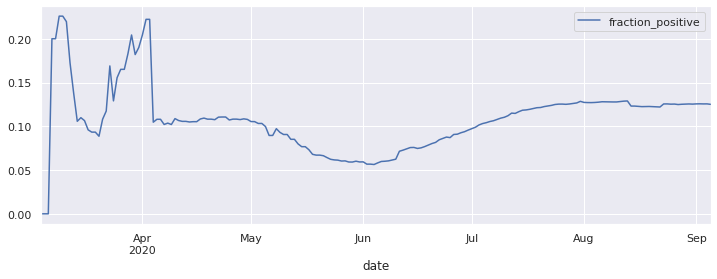

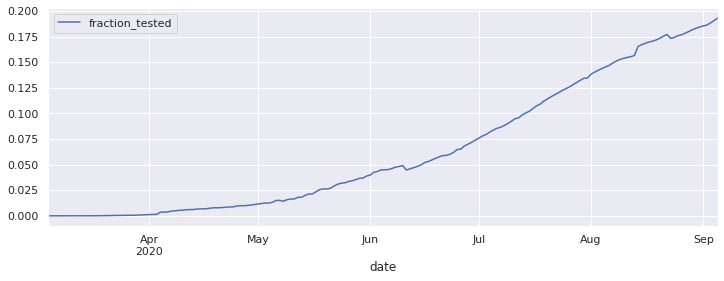

State=MA  (last_update=2020-01-22T00:00)
Doubling every -1.03e+02 days based on last 10 days of data


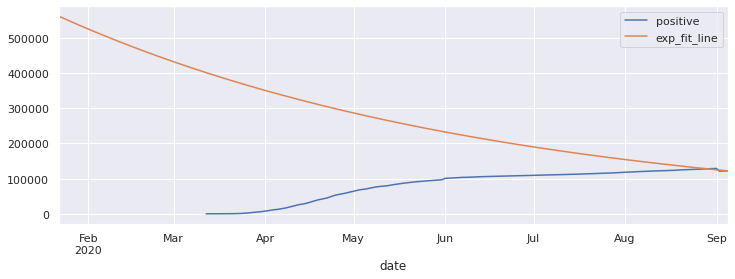

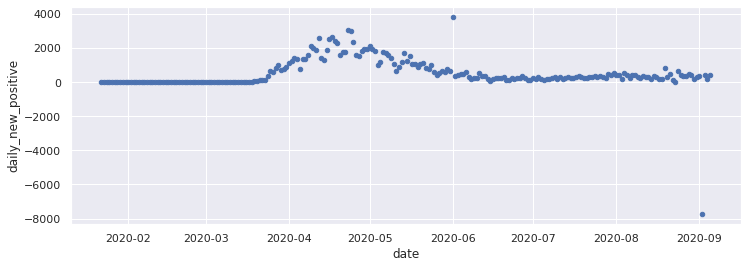

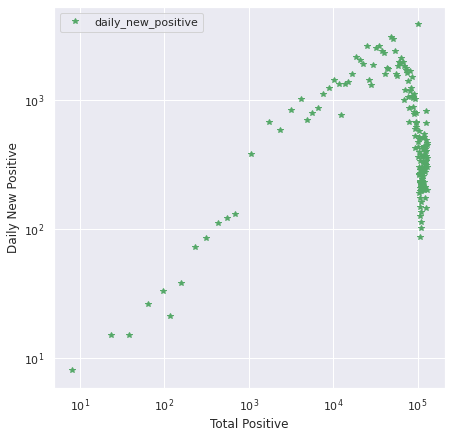

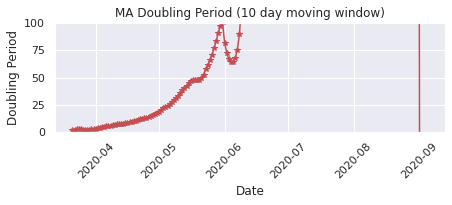

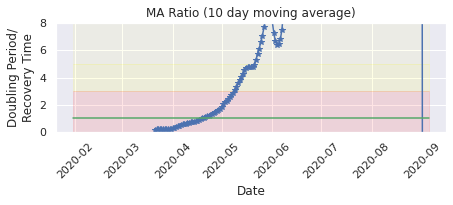

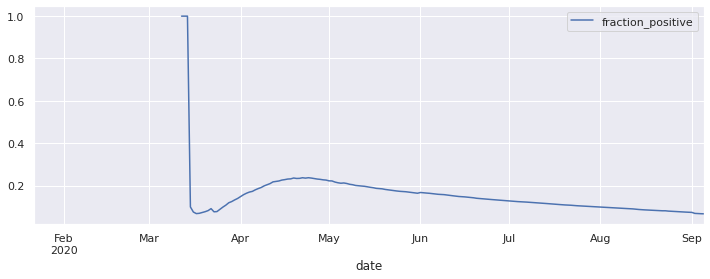

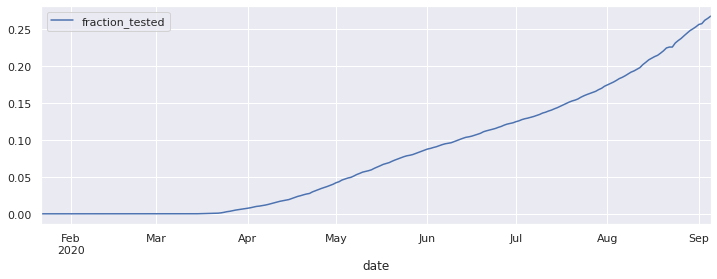

State=MI  (last_update=2020-03-01T00:00)
Doubling every 1.04e+02 days based on last 10 days of data


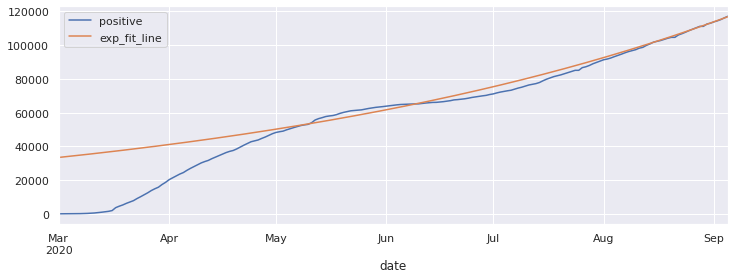

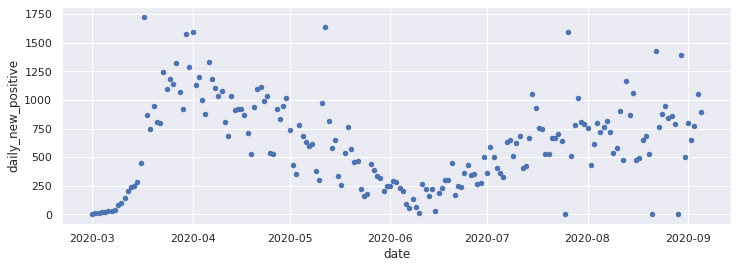

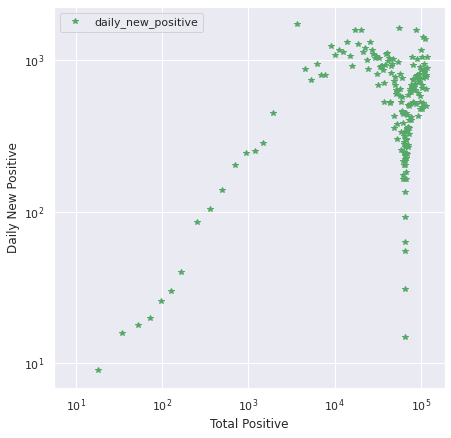

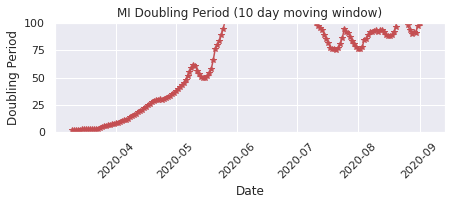

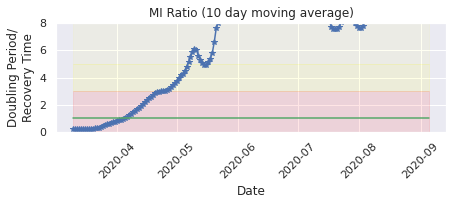

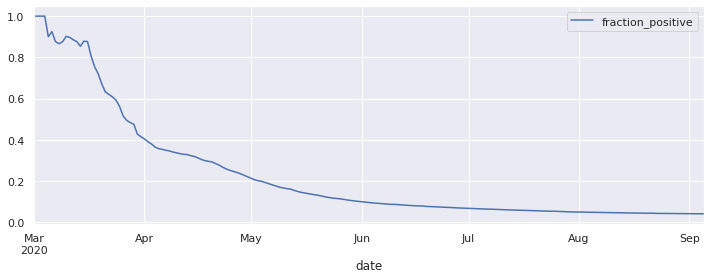

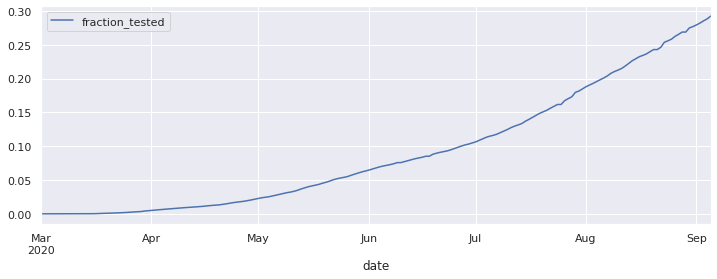

State=MD  (last_update=2020-03-05T00:00)
Doubling every 1.27e+02 days based on last 10 days of data


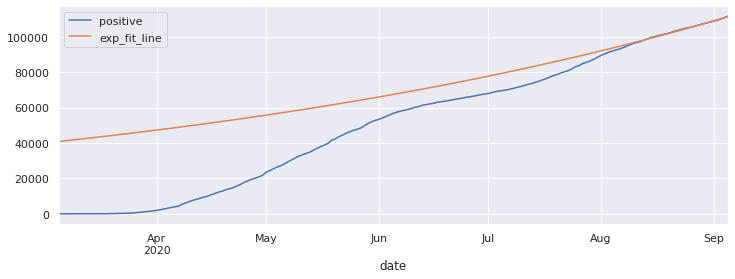

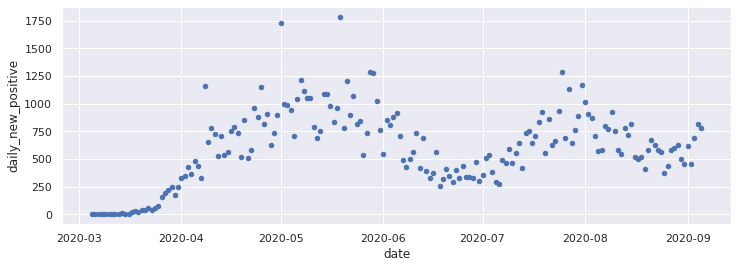

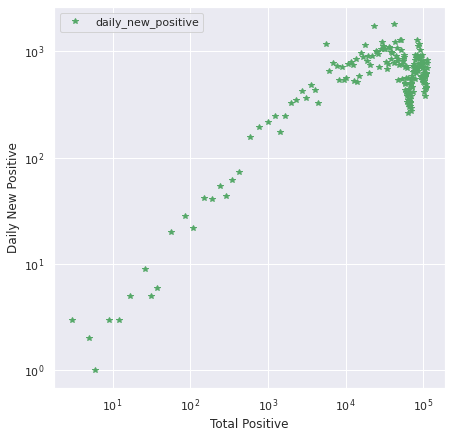

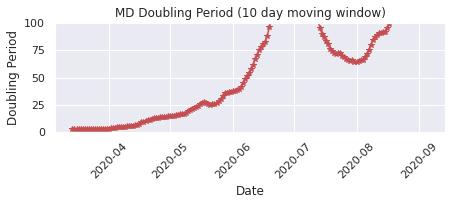

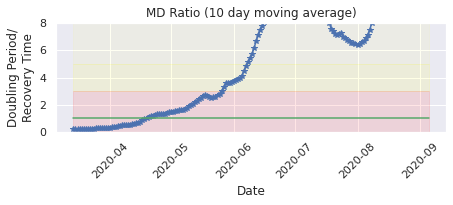

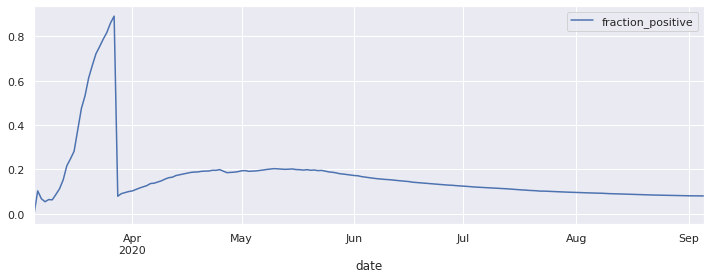

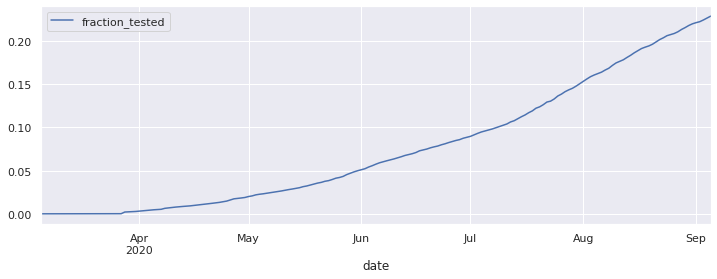

State=IN  (last_update=2020-03-06T00:00)
Doubling every 71.1 days based on last 10 days of data


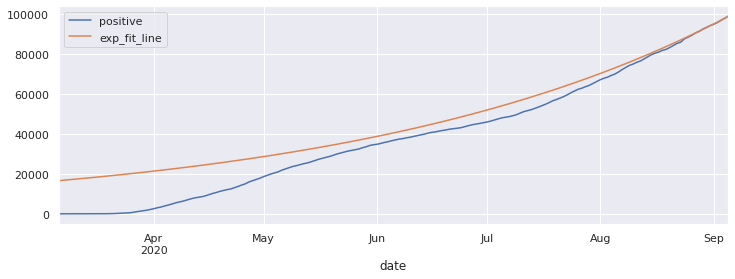

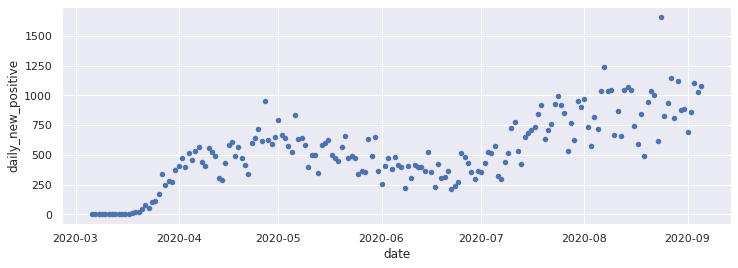

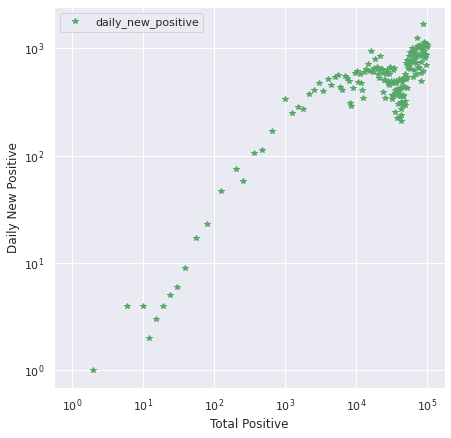

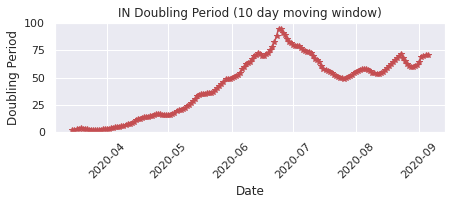

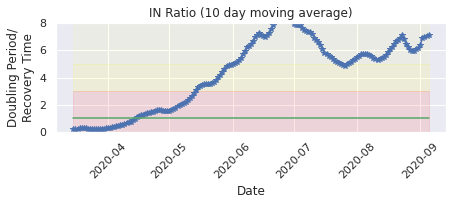

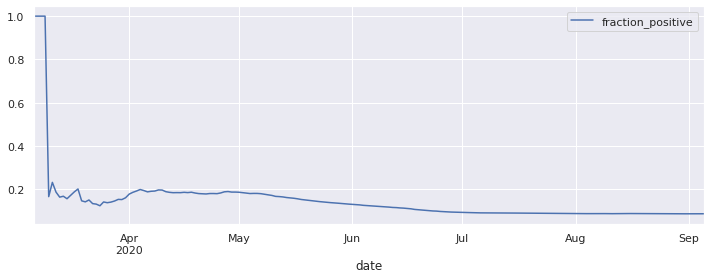

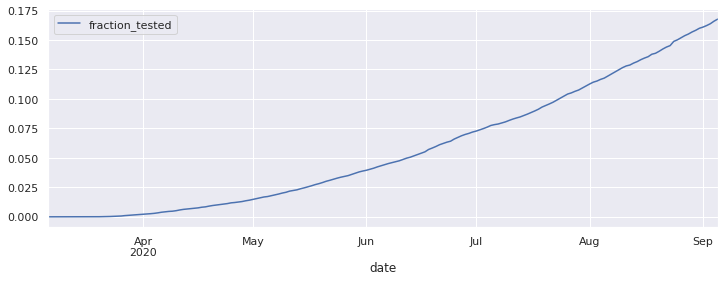

State=MO  (last_update=2020-03-07T00:00)
Doubling every 44.1 days based on last 10 days of data


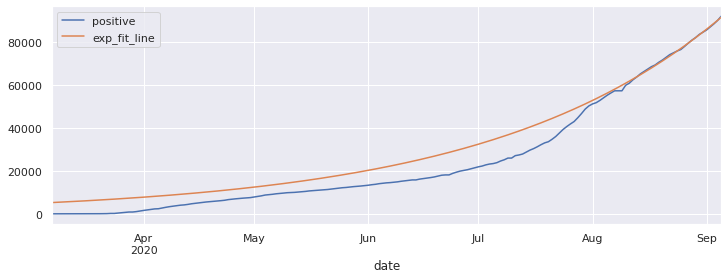

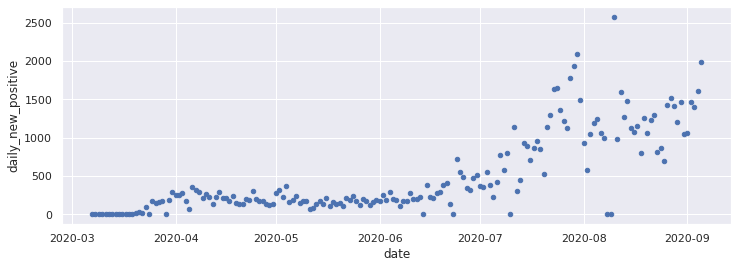

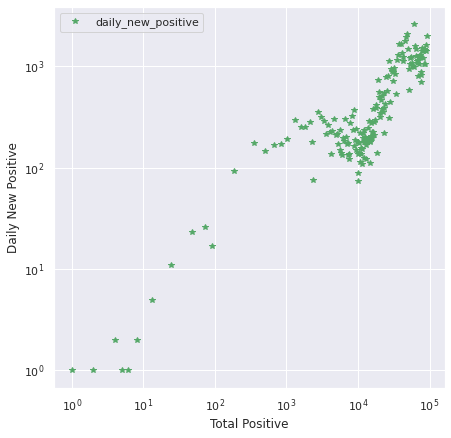

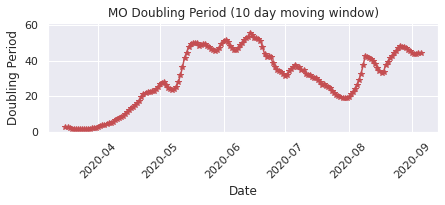

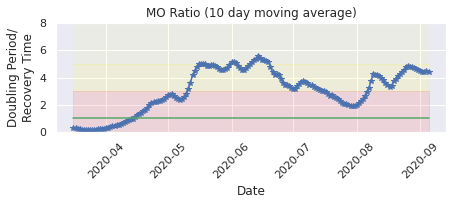

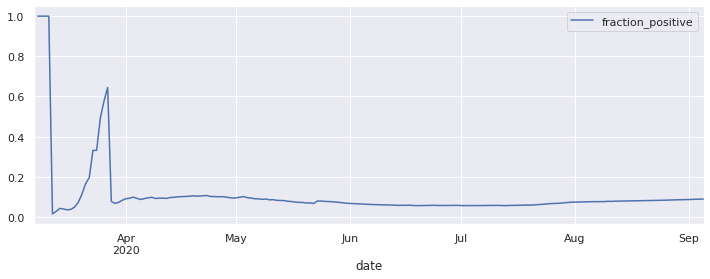

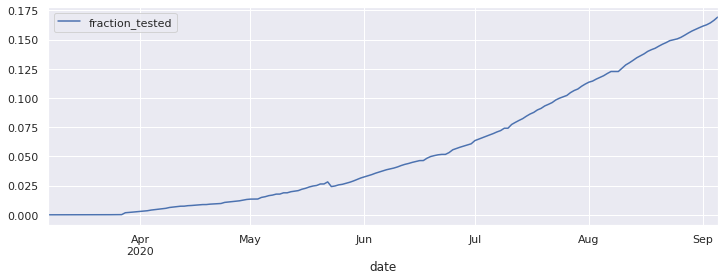

State=MS  (last_update=2020-03-07T00:00)
Doubling every 90.4 days based on last 10 days of data


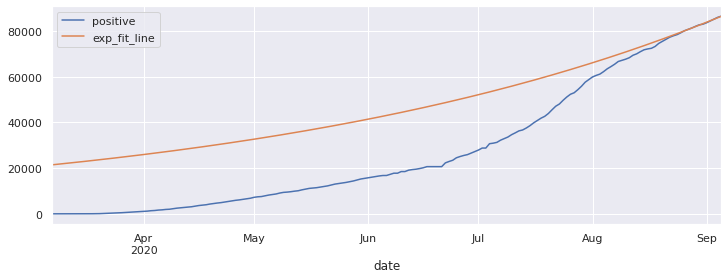

In [ ]:
last_n_days = 10
dps = []
for s in states_in_order:
    dfq, dt, _ = get_state_doubling_df(df, s, use_last_n_days=last_n_days)
    dps.append(dt)
    lu = str(dfq.date.values[0])[:16]
    print("State={}  (last_update={})".format(s, lu))
    print("Doubling every {:.3} days based on last {} days of data".format(dt, last_n_days))
    dfq.plot(x="date", y=["positive", "exp_fit_line"], figsize=[12,4])
    if len(dfq) > 1:
        dfq.plot.scatter(x="date", y="daily_new_positive", figsize=[12,4])
    dfq.plot(x="positive", y="daily_new_positive", figsize=[7,7], style="*g", 
            logy=True, logx=True)
    plt.xlabel("Total Positive")
    plt.ylabel("Daily New Positive")
    period_factor_plot(dfq,s, ylimit=8)
    plt.show()
    dfq["fraction_positive"] = dfq["positive"]/dfq["tests"]
    dfq["fraction_tested"] = dfq["tests"]/dfq["population"]
    dfq.plot("date", "fraction_positive", figsize=[12,4])
    plt.show()
    dfq.plot("date", "fraction_tested", figsize=[12,4])
    plt.show()

In [ ]:
plt.figure(figsize=[8,4])
dps = np.array(dps)
dps = dps[~np.isnan(dps)]
dp_state = dps[dps < 60]
dp_state = dp_state[dp_state > 0]
a = plt.hist(dp_state, bins=25)
plt.title("US State Doubling Periods")
plt.xlabel("Doubling Period in Days")
plt.ylabel("Number of US States")
plt.show()
# or in terms of resolution time
plt.figure(figsize=[8,4])
resolution_time = 10
a = plt.hist(dp_state/resolution_time, bins=25)
plt.title("US State Doubling Periods")
plt.xlabel("Doubling Period/Resolution Time")
plt.ylabel("Number of US States")
plt.show()

### Rolling Doubling Period World

In [ ]:
dfw, cl = get_dataset_df_from_files(in_filename)
print(dfw.head())
print(dfw.columns)

In [ ]:
period_factor_plot(dfw,"CHN")
period_factor_plot(dfw,"KOR")
period_factor_plot(dfw,"ITA")
period_factor_plot(dfw,"ESP")
period_factor_plot(dfw,"GBR")
period_factor_plot(dfw,"FRA")
period_factor_plot(dfw,"IND")
period_factor_plot(dfw,"NZL")
period_factor_plot(dfw,"SWE")
period_factor_plot(dfw,"JAM")

### Rolling Doubling Period States

In [ ]:
upper_limit = 6
dfw = get_state_df(df, "*")
period_factor_plot(dfw,"*", ylimit=upper_limit)
dfw = get_state_df(df, "WA")
period_factor_plot(dfw,"WA", ylimit=upper_limit)
dfw = get_state_df(df, "NY")
period_factor_plot(dfw,"NY", ylimit=upper_limit)
dfw = get_state_df(df, "CA")
period_factor_plot(dfw,"CA", ylimit=upper_limit)
dfw = get_state_df(df, "CO")
period_factor_plot(dfw,"CO", ylimit=upper_limit)
dfw = get_state_df(df, "MI")
period_factor_plot(dfw,"MI", ylimit=upper_limit)
dfw = get_state_df(df, "FL")
period_factor_plot(dfw,"FL", ylimit=upper_limit)

### Big Grid of Daily Total Verified Covid-19 Cases by State

In [ ]:
g = sns.FacetGrid(df, col="state", col_wrap=5, height=3, margin_titles=True)
g.map(plt.plot,"date","positive",color="b")
g.map(plt.xticks, rotation=45)